# Homework 4: Dynamic Programming

In this assignment you will implement the *value iteration* algorithm and apply it to the Frozen Lake and Gambler's environments. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gym.envs.toy_text.frozen_lake import FrozenLakeEnv
import os
from scipy.stats.distributions import poisson

### Excerise 1 (\# Points):

Implement value iteration for the gambler's problem, detailed below.

#### Gambler's Environment

This exercise uses the Gambler's Problem detailed in Example 4.3 in [SB](http://incompleteideas.net/book/the-book-2nd.html). The important details are described here:

A gambler has the opportunity to make bets on the out comes of a sequence of coin flips. If the coin comes up as heads, he wins as many dollars as he has staked on that flip; if it is tails, he loses his stake. The game ends when the either the gambler reaches his goal of \$100 or he loses all his money. On each flip, the gambler must decide how much of his capital to stake.

The state-value function gives the probability of winning from each state. A policy is a mapping from the amount of capital to states. The optimal policy maximizes the probablitiy of reaching the goal. Let $p_h$ denote the probability of the coin coming up heads.

* **State Space:** $s \in \{1, 2, ..., 100\}$
* **Action Space:** $a \in \{0, 1, ..., \min(s, 100-s)\}$
* **Reward:** $\begin{cases}
                       +1 & s = 100 \\
                       0 & otherwise
               \end{cases}$

In [2]:
def PR(s, a, s_prime,p_h):
    if s_prime == s+a:
        return p_h, int(s_prime==100)
    elif s_prime == s-a:
        return 1-p_h, 0
    else:
        return 0, 0

In [3]:
def plot(V, policy, iteration):
    os.system("mkdir -p gambler_figures")
    
    fig, axes = plt.subplots(1, 2)

    ax = axes[0]
    im = ax.plot(V)
    ax.set_title('V')
    
    ax = axes[1]
    im = ax.bar(range(101),policy)
    ax.set_title('policy')
    
    plt.savefig('gambler_figures/result_iter_%02i.png' % iteration)

    plt.clf()




In [11]:
def gamblers_value_iteration(p_h, theta=1e-4, gamma=1.0):
    """
    Args:
        env: OpenAI Gym environment
        theta: Threshold used to determine accuracy of estimation
        gamma: Discount factor
    Returns:
        A tuple (policy, value function)
    """
    V = np.zeros(101)
    policy = np.zeros(101)
    iteration=0
    Delta = np.inf
    p_h=p_h

    while True:
        iteration+=1
        Delta = 0
        for s in range(1,101):
            if s==100:
                break
            v = V[s]
            argmax_a = -np.inf
            max_return = -np.inf
            for a in range(0,min(s,100-s)+1):
                value_sa = 0
                for s_prime in [s-a, s+a]:
                    P, R = PR(s,a,s_prime,p_h)
                    value_sa += P * (R + gamma * V[s_prime])
#                     print 'V[s_prime]:',V[s_prime]
#                     print 'R:',R
#                     print 'value_sa:',value_sa
                if value_sa> max_return:
                    max_return = value_sa
                    argmax_a = a
                # if expected_return == max_return:
                #     argmax_a = np.random.choice([a, argmax_a])

            V[s] = max_return
            policy[s] = argmax_a
            Delta = max(Delta, np.abs(v-V[s]))
        if Delta<theta:
            break
    return policy, V

#### Show your results in terms of the greedy policy as a function of state for your calculated value function. Your results should match those in Figure 4.3 from SB.

In [12]:
policy, V = gamblers_value_iteration(p_h=0.4, theta=1e-4, gamma=1.0)

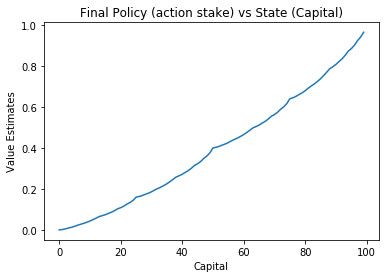

In [13]:
x = range(100)
y = V[:100]
plt.plot(x, y)
plt.xlabel('Capital')
plt.ylabel('Value Estimates')
plt.title('Final Policy (action stake) vs State (Capital)')
plt.show()

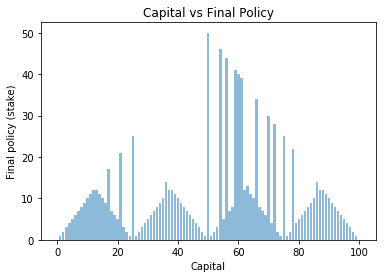

In [14]:
x = range(101)
y = policy
plt.bar(x, y, align='center', alpha=0.5)
plt.xlabel('Capital')
plt.ylabel('Final policy (stake)')
plt.title('Capital vs Final Policy')
plt.show()

### Excerise 2 (\# Points):

Implement value iteration for any arbritary Gym environemnt provided there is a perfect model of the environment as a MDP. In order for a OpenAI Gym environment to have this perfect model it must have nS, nA, and P as attributes.

* **P:** Represents the transition probabilities of the environment. P[s][a] is the tuple (prob, next_state, reward, done)
* **nS:** Number of states in the environment
* **nA:** Number of actions in the environment

Note that we have added a max iterations argument to this function. While this is not necessary, it ensures that we will never be stuck running forever due to a bad $\theta$.

In [76]:
def gym_value_iteration(env, theta=1e-4, gamma=1.0, max_iterations=1000):
    """
    Args:
        env: OpenAI Gym environment which has P, nS, and nA as attributes
        theta: Threshold used to determine accuracy of estimation
        gamma: Discount factor
        max_iterations: Maximum number of value iterations to run
    Returns:
        A tuple (policy, value function)
    """
    
    V = np.zeros(env.nS)
    policy = np.zeros(env.nS)
    iteration=0
    while True:
        iteration+=1
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(env.nS):
            v = V[s]
            argmax_a = -np.inf
            max_return = -np.inf
            for a in range(env.nA):
                value_sa = 0
                for prob, next_state, reward, done in env.P[s][a]:
                    value_sa += prob * (reward + gamma * V[next_state])
                if value_sa> max_return:
                    max_return = value_sa
                    argmax_a = a
          
            V[s] = max_return
            policy[s] = argmax_a
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(v - V[s]))       
        # Check if we can stop 
        if delta < theta:
            break
        elif iteration==max_iterations:
            break
    
    
    return policy, V

#### Test your implementation on the Frozen Lake environment

In [81]:
frozen_lake = FrozenLakeEnv()
policy, V = gym_value_iteration(frozen_lake)
expected_policy = np.array([0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0])
np.testing.assert_array_equal(policy, expected_policy)